# Interactive learning "Active learning" 


This is a playground created as an active learning setting for the course [Interactive Machine Learning](https://www.mah.se/upload/FAKULTETER/TS/Forskning/Kursplan%20Interaktiv%20maskininl%C3%A4rning.pdf). Active learning is is a setting that is between supervised and unsupervised learning. We have some labelled data but the majority of the data is [unlabelled](https://en.wikipedia.org/wiki/Active_learning_(machine_learning) ). The special feature of Active learning is that the active learning algorithm choses incoming samples/data that needs labelling.

The setup is inspired and by the article [Active Learning With Drifting Streaming Data](https://ieeexplore.ieee.org/document/6414645). 
For the machine learning the framework from [fast.ai](http://www.fast.ai/) is used, that framework is an extention of [PyTorch](https://pytorch.org/). A lot of inspiration for this is taken from the first lesson at [fastai](http://course.fast.ai/)

### The problem
In the example below a mockup is built for sorting batteries. The batteries comes into the system and decisions has to be made to sort them as chargeable or alkaline. There is no going back and resort the batteries. Since the incoming batteries can be dirty or of an previously unseen brand and type classification can be problematic. There needs to be a way to update the classifier so it can handle the changes in incoming batteries. As such, it is a typical active learning problem. To be able to quantify the results we need a budget, a cost for labeling and a penalty for wrongly sorted batteries. Total budget and labelling cost is easy to estimate but the penalties on wrongly sorted batteries is a more complicated number. In this case, this probably has to be estimated by a manual inspection of the sorted material. Another source of error is that alkaline batteries are much more common that chargeable and that it is worse to sort chargeable as alkaline the other way around. To this comes of course different costs to recycle different battery types. As said this is a huge simplification of an important problem where manual sorting is not a work that many people would choose if there were alternatives.

### Machine learning algorithm
In this mockup a CNN (Convolutional Neural Network) is used to sort the batteries. CNN's is preferably used to classify images, in this case we use a pretrained model resnet-34 as a start. In this test we only use less than 100 images to train the model so it can be used for prediction. In this case we have taken around 5 images on each battery from different angels and divided the images in train, validation and test set. Test set is around 30% of all images. The rest of the data is labelled data (70% of total data) is divided as 70% training set and 30% validation set.

![setup][setupimg]
_A visualisation of the setup, the batteries moves forward on the conveyer belt, the camera takes images and decides first if the battery should be labelled and second if it should be sorted as chargeable (contains Pb,Cd,Ni,Hg) or as an alkaline battery._

### Exploration and explotation
We can expect context drift both abrupt when completely new battery brands enter and also gradually when the design and colouring of brands change. This indicates that we need a strategy to label some of the batteries that comes in.

In the [article](https://ieeexplore.ieee.org/document/6414645) we use as inspiration four strategies are outlined that balance exploitation and exploration to select batteries to label. We have implemented two, one random (exploration) and one based on accuracy (exploitation). Other algorithms combine the strategies and balance exploration and exploitation.

### Metric
In this example we sort batteries in two classes "alkaline" and "chargeable". We have used a extremely simplified budget of 10 units and a labelling cost of 2 units. The budget of course has to be per time unit and there needs to be penalties for wrongly sorted batteries.

### Some information around sorting
A real world solution that uses machine learning to sort batteries can be seen here [film](https://www.youtube.com/watch?feature=player_embedded&v=OugqnVO7WiU). And som infomation around the problem i [general (in swedish](https://www.sopor.nu/fakta-om-sopor/vad-haender-med-din-sopa/elavfall/batterier)

[setupimg]: images/setup.jpg "Setup"


In [6]:
# Som get started crap run this first
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))
import sys
import zipfile
import platform
#sys.path.append("../")
from fastaiold.imports import *
print(platform.python_version())
from fastaiold.transforms import *
from fastaiold.conv_learner import *
from fastaiold.model import *
from fastaiold.dataset import *
from fastaiold.sgdr import *
from fastaiold.plots import *
# set some variables
#PATH = "data/batteries_v1/batteries/" First version
#PATH = "data/batteries_v4/"
PATH = "data/spisaribb_v1/spisaribb"
arch=resnet34  ##Using the resnet34 model
sz=224
print(f'NVidia GPUs is called CUDA aviable {torch.cuda.is_available()}')
print(f'deep learning accelerator aviable CuDNN {torch.backends.cudnn.enabled}')

3.6.5
NVidia GPUs is called CUDA aviable True
deep learning accelerator aviable CuDNN True


## Utility functions
Run this to unpack images that will be used for learning.

In [3]:
#Unpack images from zipfile to data lib
#% rm -rf (mydata/tools
with zipfile.ZipFile("data/spisaribb.zip","r") as zip_ref:
    zip_ref.extractall("data/spisaribb_v1")


## Train batteries

In [9]:
# Uncomment below if you need to reset your precomputed activations
#shutil.rmtree(f'{PATH}tmp', ignore_errors=True)
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz), test_name="test")
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 100)
#prints training loss, validation loss and accuracy
learn.save("spisaribb_v1")

100%|██████████| 1/1 [00:15<00:00, 15.90s/it]


epoch      trn_loss   val_loss   accuracy   
    0      1.207066   0.741164   0.481481  
    1      1.217331   0.697146   0.518519  
    2      1.102161   0.690009   0.518519  
    3      1.019172   0.74691    0.555556  
    4      0.923825   0.818814   0.481481  
    5      0.856614   0.869912   0.481481  
    6      0.804347   0.900507   0.481481  
    7      0.77061    0.905723   0.481481  
    8      0.722212   0.895738   0.518519  
    9      0.678385   0.879664   0.518519  
    10     0.650529   0.846984   0.592593  
    11     0.610389   0.820739   0.592593  
    12     0.57832    0.794124   0.62963   
    13     0.55043    0.766679   0.666667  
    14     0.520452   0.742229   0.666667  
    15     0.498581   0.724506   0.703704  
    16     0.477377   0.716481   0.703704  
    17     0.45582    0.711435   0.740741  
    18     0.439397   0.708522   0.777778  
    19     0.418391   0.712097   0.777778  
    20     0.400076   0.722585   0.777778  
    21     0.386501   0.733816 

In [21]:
#transforms_top_down, transforms_side_on, transforms_basic 
shutil.rmtree(f'{PATH}tmp', ignore_errors=True)
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_top_down, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, test_name=None)
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(1e-2, 50)

epoch      trn_loss   val_loss   accuracy   
    0      0.768341   0.764874   0.555556  
    1      0.736373   0.73748    0.555556  
    2      0.743823   0.705509   0.555556  
    3      0.708808   0.689608   0.62963   
    4      0.677548   0.701504   0.481481  
    5      0.61551    0.736322   0.555556  
    6      0.598142   0.780284   0.62963   
    7      0.565697   0.822756   0.62963   
    8      0.536276   0.855535   0.666667  
    9      0.495852   0.887879   0.703704  
    10     0.475232   0.906746   0.703704  
    11     0.447977   0.910324   0.666667  
    12     0.425959   0.917142   0.666667  
    13     0.402552   0.910388   0.666667  
    14     0.380499   0.899358   0.666667  
    15     0.360811   0.901756   0.703704  
    16     0.343357   0.914006   0.703704  
    17     0.330984   0.929733   0.703704  
    18     0.319224   0.947857   0.703704  
    19     0.304855   0.969475   0.703704  
    20     0.293149   0.989204   0.703704  
    21     0.282488   1.001259 

[array([1.6304]), 0.6666666865348816]

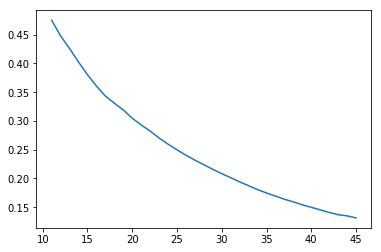

In [22]:
learn.sched.plot_loss()

## View training and validation set for batteries

In [38]:
# Run to register the plot functions
#And I know verbose.....
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        try:
            sp = f.add_subplot(rows, len(ims)//rows, i+1)
        except ValueError:
            print("")
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])
        
def plot_images_from_train_set(train_y):
    imgs=[]
    titles=[]
    res = np.extract(data.trn_y==train_y,data.trn_ds.fnames)
    printmd("# "+data.classes[train_y]+"s in training set")
    for i in range(0,len(res)):
        title = res[i]
        #print(title)
        imgs.append(plt.imread(PATH + res[i]))
        titles.append(title)    
    return plots(imgs,titles=titles,rows=10,figsize=(20,16))

def plot_images_from_val_set(val_y):
    imgs=[]
    titles=[]
    res = np.extract(data.val_y==val_y,data.val_ds.fnames)
    printmd("# "+data.classes[val_y]+"s in validation set")
    for i in range(0,len(res)):
        title = res[i]
        #print(title)
        imgs.append(plt.imread(PATH + res[i]))
        titles.append(title)    
    return plots(imgs,titles=titles,rows=5,figsize=(16,8))

#print("The classes: "+str(data.classes))
#print("And the validation set alkaline is 0 and chargeable is 1:" +str(data.val_y))

# alkalines in training set

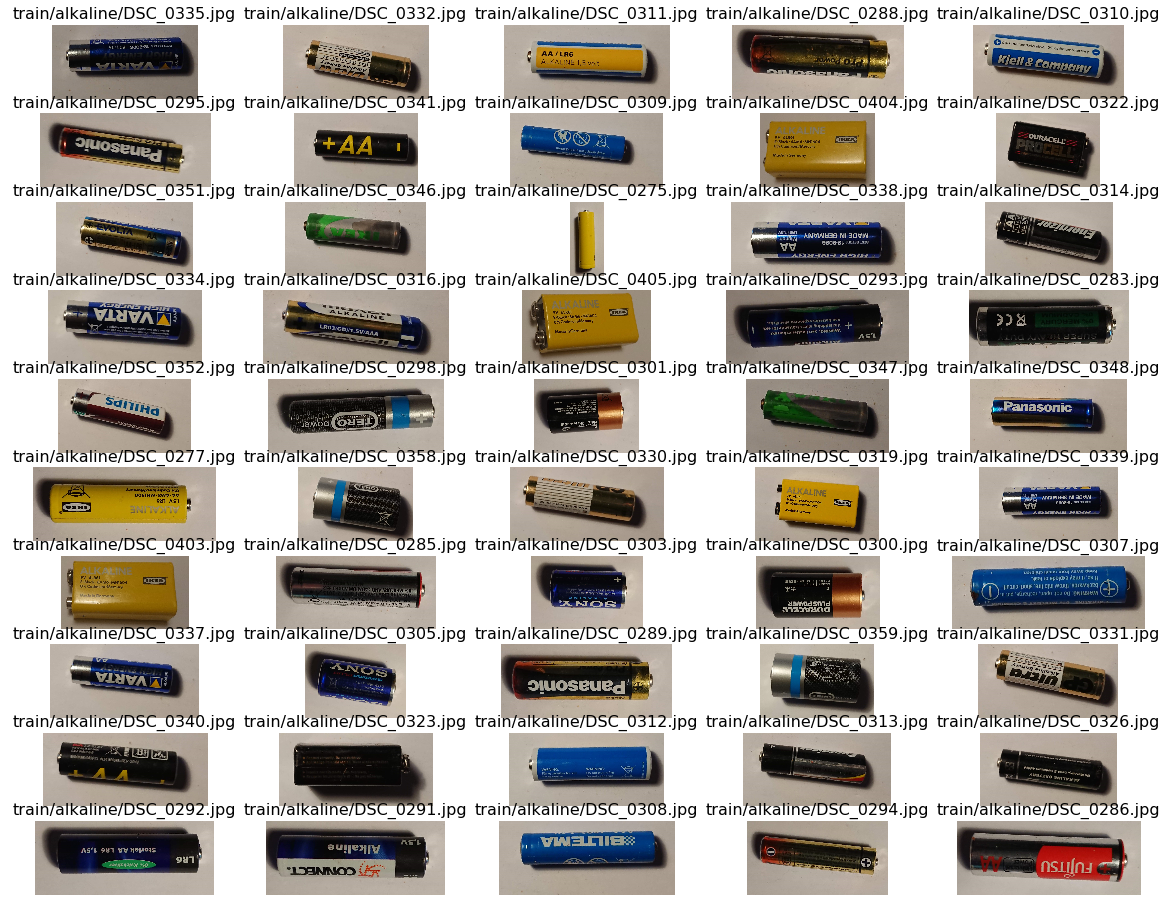

In [29]:
#Alkalines
plot_images_from_train_set(0)

# chargeables in training set

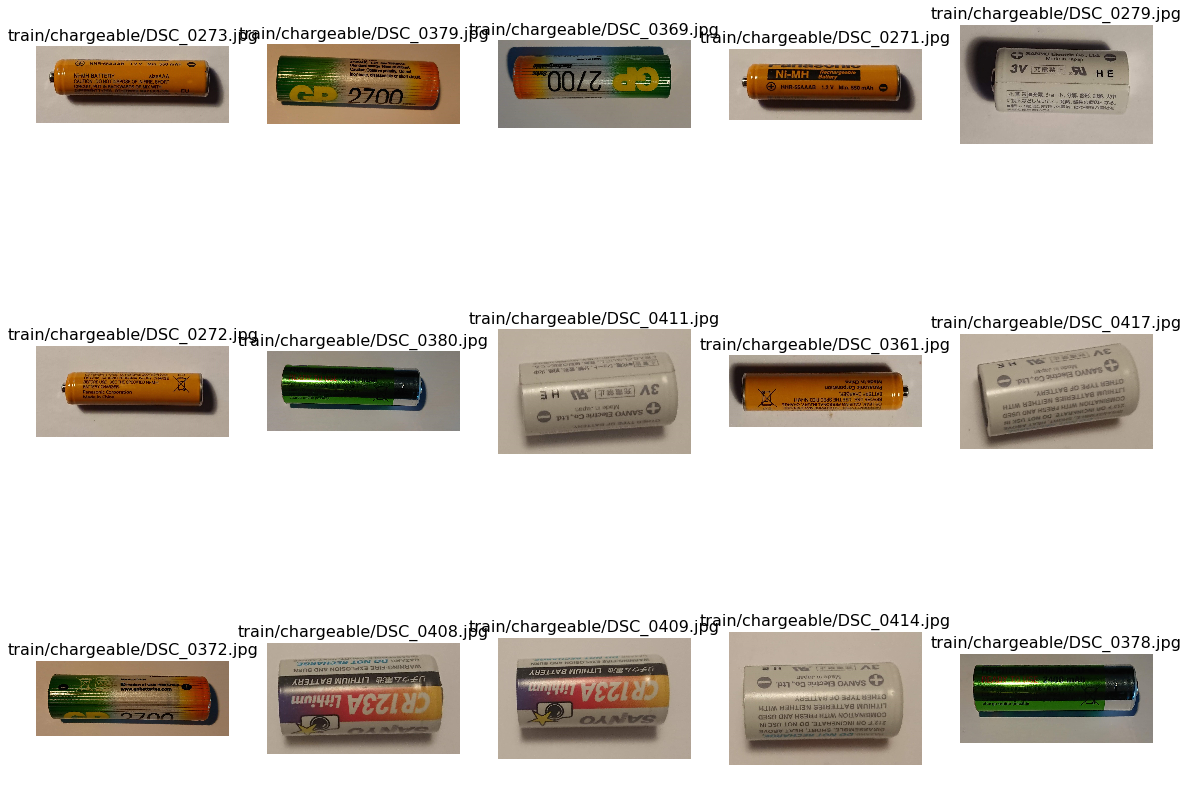

In [25]:
#Chargeables
plot_images_from_train_set(1)

# alkalines in validation set

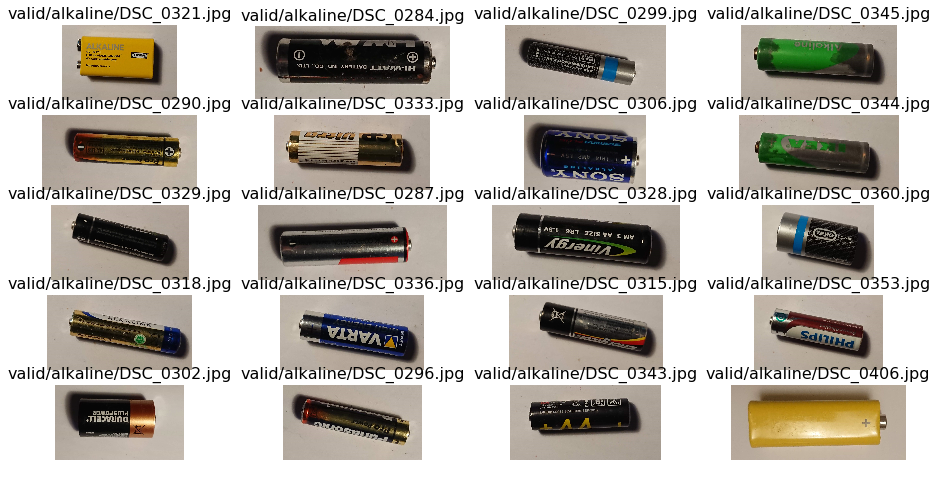

In [26]:
#Alkalines
plot_images_from_val_set(0)

# chargeables in validation set

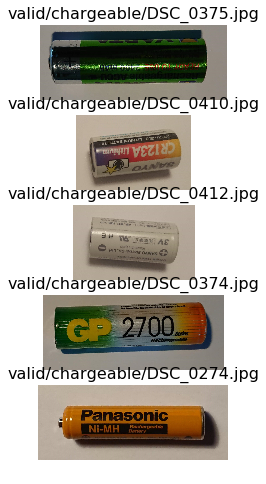

In [30]:
#Chargeables
plot_images_from_val_set(1)

## Confusion matrix 

Accurracy validation set: 0.67
Recall for alkaline: 0.93
Precision for alkaline: 0.64
Recall for chargeable: 0.33
Precision for chargeable: 0.8
[[14  1]
 [ 8  4]]


FileNotFoundError: [Errno 2] No such file or directory: 'data/spisaribb_v1/spisaribbvalid/one/DSC_0205.JPG'

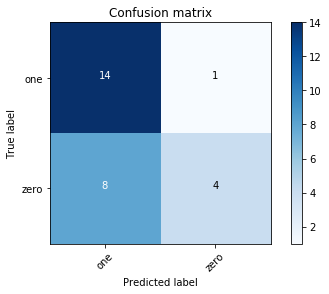

In [23]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)
print("Accurracy validation set: "+str(np.around(accuracy_np(probs, y),decimals=2)))
preds = np.argmax(probs, axis=1)
probs = probs[:,1]
from sklearn.metrics import confusion_matrix
#accuracy_np(probs, y)
cm = confusion_matrix(y, preds)
#Recall = how many correct among the ones in the bin (ideally max 1)
print("Recall for alkaline: "+str(np.around(cm[0,0]/(cm[0,1]+cm[0,0]),decimals=2)))
#Recall = how many correct classified among all that should be among all correct (ideally max 1).
print("Precision for alkaline: "+str(np.around(cm[0,0]/(cm[0,0]+cm[1,0]),decimals=2)))
print("Recall for chargeable: "+str(np.around(cm[1,1]/(cm[1,1]+cm[1,0]),decimals=2)))
print("Precision for chargeable: "+str(np.around(cm[1,1]/(cm[1,1]+cm[0,1]),decimals=2)))
plot_confusion_matrix(cm, data.classes)

wrong_validation=np.where(np.add(y,preds) == 1)[0]

def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        try:
            sp = f.add_subplot(rows, len(ims)//rows, i+1)
        except ValueError:
            print("")
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

def print_wrong_validation():
    img = []
    titles = []
    for i in range (0,len(wrong_validation)):
        path = PATH +data.val_ds.fnames[wrong_validation[i]]
        img.append(plt.imread(path))
        titles.append(data.val_ds.fnames[wrong_validation[i]]+":"+data.classes[preds[wrong_validation[i]]])
        #print (data.val_ds.fnames[wrong_validation[i]]+":"+data.classes[y[wrong_validation[i]]])
        #print("Classified as: "+data.classes[preds[wrong_validation[i]]]+" should be "+data.classes[y[wrong_validation[i]]])
    plots(img,titles=titles,rows=1,figsize=(20,14))

print_wrong_validation()    


## Predictions on test set

Sorted in accuracy order, closer to 0 the model belives it is a alkaline, closer to 1 the model belives it is a chargeable battery. So now we will know if it overfitted or included variance/bias.

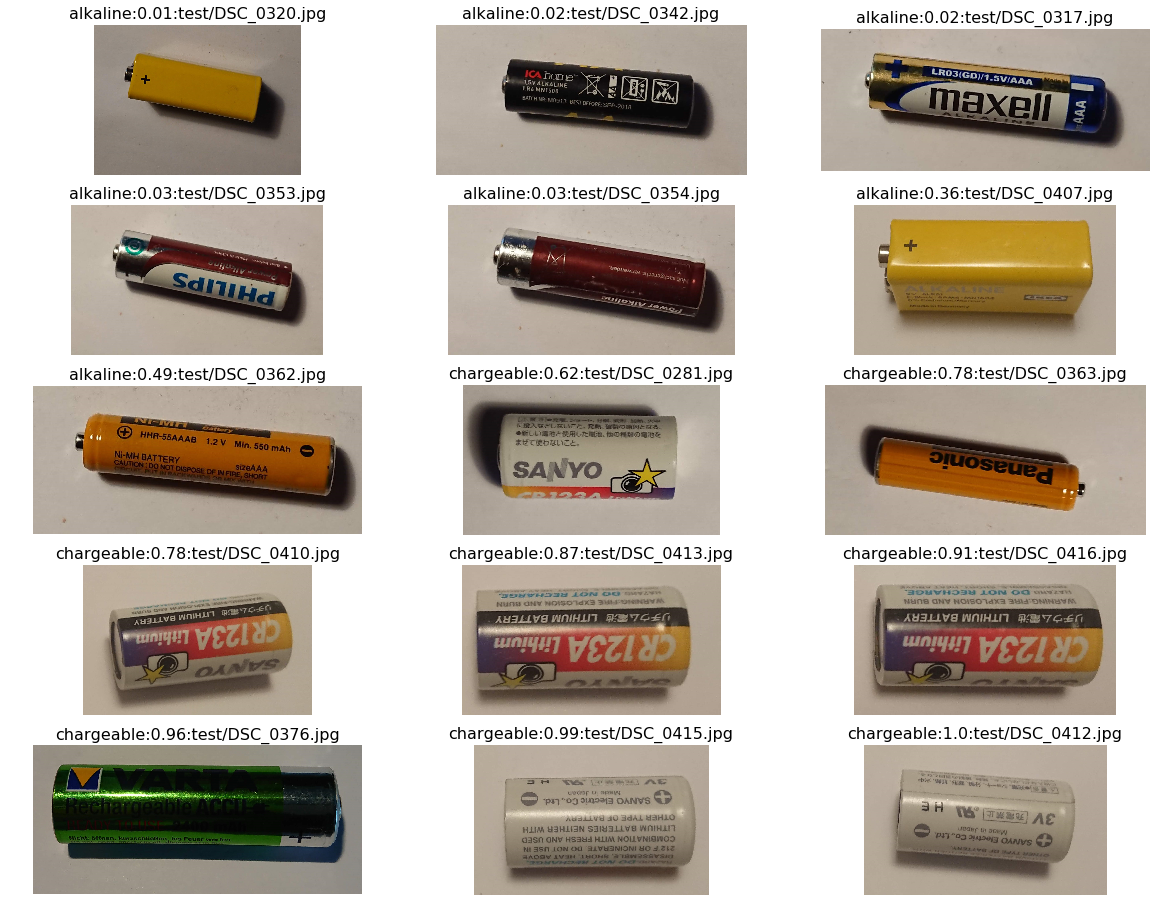

In [10]:
def plot_predictions_in_accuacy_order():
    log_preds=learn.predict(is_test=True) 
    #probs = np.round(np.exp(log_preds[:,1])*100,decimals=0) ##Convert result from log scale (probs given in log...)
    probs = np.exp(log_preds[:,1])
    names = data.test_ds.fnames
    probs_sorted = np.sort(probs)
    #print(probs)
    #print(names)
    img_names_sorted_on_probs = [x for _,x in sorted(zip(probs,names))]
    img = []
    titles = []
    for i in range(0,len(data.test_ds.fnames)):
    #for i in range(0,4):
        title = PATH + img_names_sorted_on_probs[i]
        img.append(plt.imread(title))
        titles.append(data.classes[int(probs_sorted[i]+0.5)]+":"+str(np.around(probs_sorted[i],decimals=2))+":"+img_names_sorted_on_probs[i])    
    return plots(img,titles=titles,rows=5,figsize=(20,16))

plot_predictions_in_accuacy_order()

In [ ]:
#Unpack images from zipfile to data lib
#% rm -rf (mydata/tools
with zipfile.ZipFile("data/batteries_v4.zip","r") as zip_ref:
    zip_ref.extractall("data/")
